In [1]:
# Check if installation was succesful.
try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

import time
import itertools
import numpy as np

# Graphics and plotting.
print('Installing mediapy:')
# !command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
# !pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

from IPython.display import clear_output
clear_output()

libdecor-gtk-WARNING: Failed to initialize GTK
Failed to load plugin 'libdecor-gtk.so': failed to init
No plugins found, falling back on no decorations


""

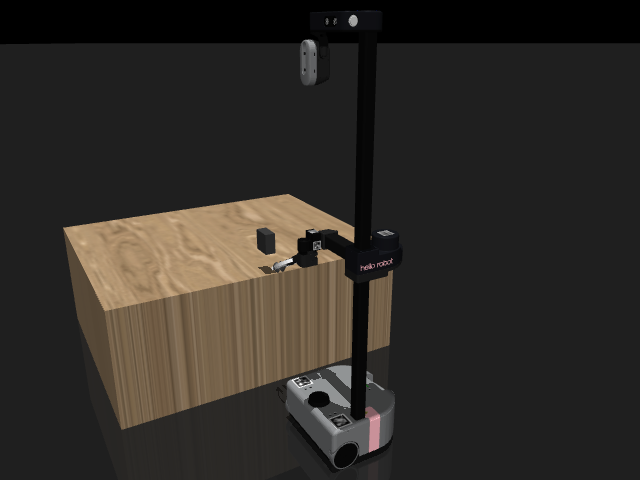

In [2]:
from pathlib import Path
import enum
from tqdm import tqdm

class Resolution(enum.Enum):
  SD = (480, 640)
  HD = (720, 1280)
  UHD = (2160, 3840)

res = Resolution.SD
h, w = res.value

model_dir = Path("mujoco_menagerie/hello_robot_stretch") # You could also use google_robot
model_xml = model_dir / "scene.xml"

# Load model.
model = mujoco.MjModel.from_xml_path(str(model_xml))
data = mujoco.MjData(model)

# Make sure offscreen rendering can support the desired resolution.
model.vis.global_.offheight = h
model.vis.global_.offwidth = w

renderer = mujoco.Renderer(model, height=h, width=w)

mujoco.mj_forward(model, data)
renderer.update_scene(data)
media.show_image(renderer.render())

In [3]:
for key in range(model.nkey):
  mujoco.mj_resetDataKeyframe(model, data, key)
  mujoco.mj_forward(model, data)
  renderer.update_scene(data)
  media.show_image(renderer.render())

In [4]:
def arc_centre(x1, y1, x2, y2, tangent_angle):
    chord_angle = atan2(y2 - y1, x2 - x1)
    arc_angle = 2 * chord_angle
    if arc_angle > 2 * pi:
        arc_angle -= 2 * pi
    elif arc_angle < 2 * pi:
        arc_angle += 2 * pi
    x3 = x1 + (x2 - x1) * cos(arc_angle) - (y2 - y1) * sin(arc_angle)
    y3 = y1 + (x2 - x1) * sin(arc_angle) + (y2 - y1) * cos(arc_angle)
    return x3, y3, arc_angle

In [5]:
vis = mujoco.MjvOption()
vis.geomgroup[2] = True
vis.geomgroup[3] = False
coll = mujoco.MjvOption()
coll.geomgroup[2] = False
coll.geomgroup[3] = True
coll.flags[mujoco.mjtVisFlag.mjVIS_CONVEXHULL] = True

camera = mujoco.MjvCamera()
mujoco.mjv_defaultFreeCamera(model, camera)
camera.distance = 6

duration = 10
fps = 30
nsteps = int(np.ceil(duration / model.opt.timestep))

# Set the desired control point.
if model.nkey > 0:
  mujoco.mj_resetDataKeyframe(model, data, 0)
  ctrl0 = data.ctrl.copy()
else:
  mujoco.mj_resetData(model, data)
  ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)


In [11]:
from math import *

class Robot:
    def __init__(self, model, data, vis, coll, camera):
        self.model = model
        self.data = data
        self.vis = vis
        self.coll = coll
        self.camera = camera
        self.x = 0
        self.y = 0
        self.tangent_angle = 0
        self.velocity = 0.0
        self.breadth = 0.0
        self.dt = model.opt.timestep
        self.treshold = 1
        self.positions = list()
        self.calc_positions = list()

    def set_wheel_speeds(self, left_speed, right_speed):
        self.data.joint('joint_left_wheel').qvel = np.array([left_speed])
        self.data.joint('joint_right_wheel').qvel = np.array([right_speed])        
        # print(left_speed, right_speed)
        # data.ctrl[0] = -1 * (left_speed + right_speed) / 2.0

    def distance_to_point(self, x_goal, y_goal, x, y):
        return sqrt((x_goal - x) ** 2 + (y_goal - y) ** 2)
    
    def arc_radius(x1, y1, x2, y2, tangent_angle):
        chord_length = sqrt((x2 - x1)**2 + (y2 - y1)**2)
        chord_angle = atan2(y2 - y1, x2 - x1)
        arc_angle = 2 * chord_angle
        if arc_angle > 2 * pi:
            arc_angle -= 2 * pi
        elif arc_angle < 2 * pi:
            arc_angle += 2 * pi
        next_tangent_angle = tangent_angle + arc_angle
        radius = (chord_length / 2) * sin(arc_angle/2)
        return radius, next_tangent_angle, chord_length, chord_angle

    def step(self, x_goal, y_goal):
        
        radius, next_tangent_angle, chord_length, chord_angle = self.arc_radius(
            self.x, self.y, x_goal, y_goal, self.tangent_angle)
        # Calc position
        delta_x = chord_length * cos(self.tangent_angle + chord_angle) * self.dt
        delta_y = chord_length * sin(self.tangent_angle + chord_angle) * self.dt
        self.x += delta_x
        self.y += delta_y
        self.tangent_angle = next_tangent_angle
        # Set wheels velocities
        wheel_base = self.breadth
        v = self.velocity
        omega = v / radius
        if abs(chord_angle) < pi/2:
            left_speed = omega * (radius - wheel_base/2)
            right_speed = omega * (radius + wheel_base/2)
        else:
            left_speed = omega * (radius + wheel_base/2)
            right_speed = omega * (radius - wheel_base/2)
        if 2 * chord_angle < 0:
            left_speed = -1 * left_speed
            right_speed = -1 * right_speed        
        self.set_wheel_speeds(self, left_speed, right_speed)
        
    
    def control_robot_to_point(self, x_goal, y_goal, duration):
        
        fps = 15
        nsteps = int(np.ceil(duration / model.opt.timestep))
        frames = []

        # Set the desired control point.
        if model.nkey > 0:
            mujoco.mj_resetDataKeyframe(model, data, 0)
            ctrl0 = data.ctrl.copy()
        else:
            mujoco.mj_resetData(model, data)
            ctrl0 = np.mean(model.actuator_ctrlrange, axis=1)
        
        # Movement steps
        for i in tqdm(range(nsteps)):
            distance = self.distance_to_point(self, x_goal, y_goal, self.x, self.y)    
            if distance > self.treshold:
                self.step(self, x_goal, y_goal)
            else:
                self.set_wheel_speeds(self, 0, 0)
                # print("Reached the goal and stopped.")
            # Rendering
            # robot.positioins.append(data.geom_xpos[1])
            self.positions.append((data.body('link_right_wheel').xpos + data.body('link_left_wheel').xpos) / 2)
            self.calc_positions.append([self.x, self.y])
            mujoco.mj_step(model, data)
            if len(frames) < data.time * fps:
                renderer.update_scene(data, self.camera, scene_option=self.vis)
                vispix = renderer.render().copy().astype(np.float32)
                frame = vispix.astype(np.uint8)
                frames.append(frame)


        self.set_wheel_speeds(self, 0, 0)
        media.show_video(frames, fps=fps, loop=False)      
        

In [12]:
robot = Robot
robot.__init__(robot, model, data, vis, coll, camera)
robot.velocity = 1
robot.breadth = 1.7
robot.x, robot.y = 0, 0
robot.treshold = 1
robot.tangent_angle = 0
robot.positions = list()
duration = 30

# Set a waypoint
x_goal, y_goal = 0, 3

# Go
robot.control_robot_to_point(robot, x_goal, y_goal, duration)
# print(robot.positions)

100%|██████████| 15000/15000 [00:04<00:00, 3278.16it/s]


Отрисовка траекторий  
Координаты пришлось перевернуть, так как в симуляции робот изначально повернут и глобальные координаты иные

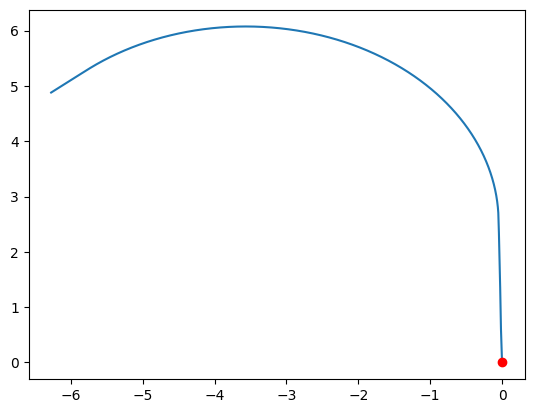

In [16]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

# Предположим, что robot.positions - это список трехмерных массивов numpy
# plt.figure()
X = []
Y = []

for position in robot.positions:
    y = position[0]
    x = - position[1]
    X.append(x)
    Y.append(y)
plt.plot(X, Y)
plt.plot(0.0, 0.0, 'ro')

# cX = []
# cY = []
# for position in robot.calc_positions:
#     y = position[0]
#     x = - position[1]
#     cX.append(x)
#     cY.append(y)
# plt.plot(cX, cY)

# centre_arc[0], centre_arc[1], arc_angle = arc_centre(0, 0, x_goal, y_goal, pi/2)
# arc = patches.Arc((arc_x, arc_y),arc_width, arc_height, theta1=0, theta2=arc_angle)


plt.show()